In [3]:
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization



In [4]:
LANDMARK_NAMES = {
    1: "S",    # Sella
    2: "Na",   # Nasion
    3: "Or",   # Orbitale
    4: "Po",   # Porion
    5: "A", # A point
    6: "B",    # B point
    7: "Pog",  # Pogonion
    8: "Me",   # Menton
    9: "Gn", # Gn point
    10: "Go",  # Gonion
    11: "L1", # L1 point
    12: "U1", # U1 point
    13: "lower apex",  # lower apex 
    14: "molar",  # molar point
    15: "upper apex",  # upper apex
    16: "premolar", # premolar point
    17: "PNS", # Posterior Nasal Spine
    18: "ANS",   # ANS point
    19: "Ar"   # Articulare
}

(256, 256, 1)
(256, 256, 19)


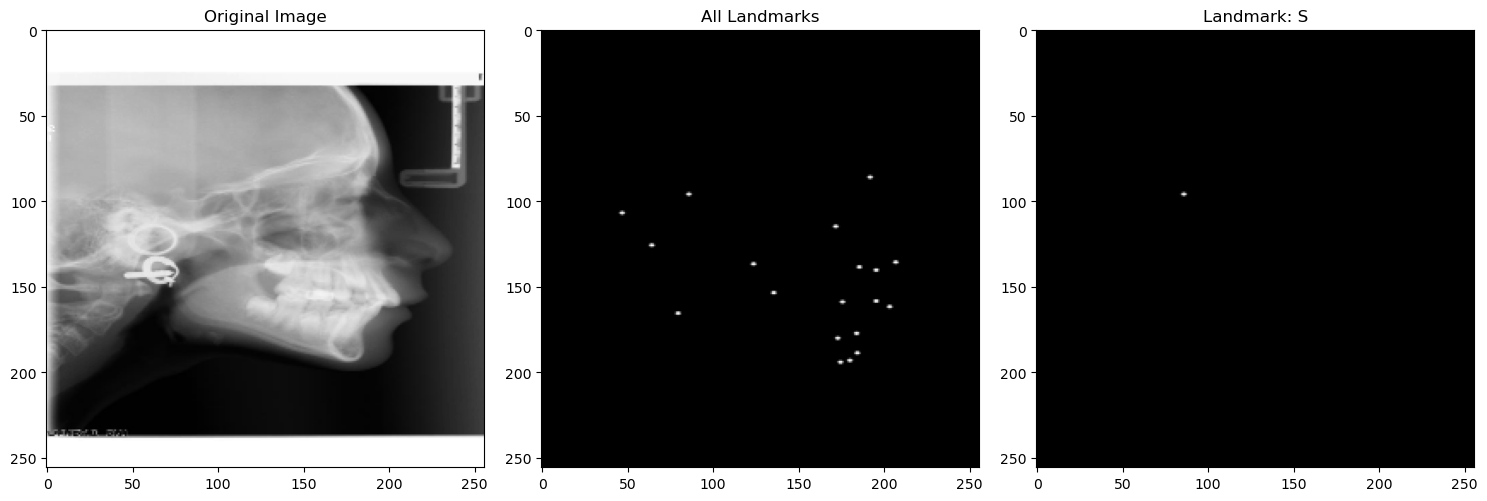

<Figure size 1500x1000 with 0 Axes>

In [5]:

train_inputImg = []
#/kaggle/input/cephalometric-landmarks
train_inputImg.append(pd.read_csv('new1200/train_senior.csv', 
                                 delimiter=',',
                                 dtype={col: float for col in range(1, 38)}))
train_inputImg.append(pd.read_csv('new1200/test1_senior.csv', 
                                 delimiter=',',
                                 dtype={col: float for col in range(1, 38)}))

w = 20
train_images = []
masks = []
train_masks = []

for csv_file in train_inputImg:
    for row in csv_file.values:
        img_landmarks = list(row)
        image = cv2.imread('new1200/ceph400/ceph400/' + str(img_landmarks[0]), 0) / 255
        Mask_Image = np.zeros((image.shape[0], image.shape[1], len(LANDMARK_NAMES)), dtype=np.uint8)
        
    
        for i, (landmark_idx, landmark_name) in enumerate(LANDMARK_NAMES.items()):
            x_idx = 2*landmark_idx - 1
            y_idx = 2*landmark_idx
            x = int(img_landmarks[x_idx])
            y = int(img_landmarks[y_idx])
            mask_layer = Mask_Image[:, :, i].astype(np.uint8)
            cv2.circle(mask_layer, (x, y), radius=4, color=255, thickness=-1)
            Mask_Image[:, :, i] = mask_layer
            Mask_Image[:, :, i] = cv2.GaussianBlur(Mask_Image[:, :, i].astype(np.float32), (5, 5), 0)
        
        masks.append(Mask_Image)
        new_image = cv2.resize(image, (256, 256))
        new_image = new_image.reshape((new_image.shape[0], new_image.shape[1], 1))
        train_images.append(new_image)
        
        resize_mask = cv2.resize(Mask_Image, (256, 256))
        train_masks.append(resize_mask)

size = new_image.shape
print(size)
print(train_masks[0].shape)

# Create a figure with multiple subplots
plt.figure(figsize=(15, 5))

# Original image
plt.subplot(131)
plt.imshow(train_images[0], cmap='gray')
plt.title('Original Image')

# Composite mask (sum of all landmark channels)
plt.subplot(132)
composite_mask = np.sum(train_masks[0], axis=2)
plt.imshow(composite_mask, cmap='gray')
plt.title('All Landmarks')

# Example of a single landmark channel (e.g., Sella point)
plt.subplot(133)
plt.imshow(train_masks[0][:,:,0], cmap='gray')  # Show first landmark channel
plt.title(f'Landmark: {list(LANDMARK_NAMES.values())[0]}')

plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
plt.tight_layout()
plt.show()

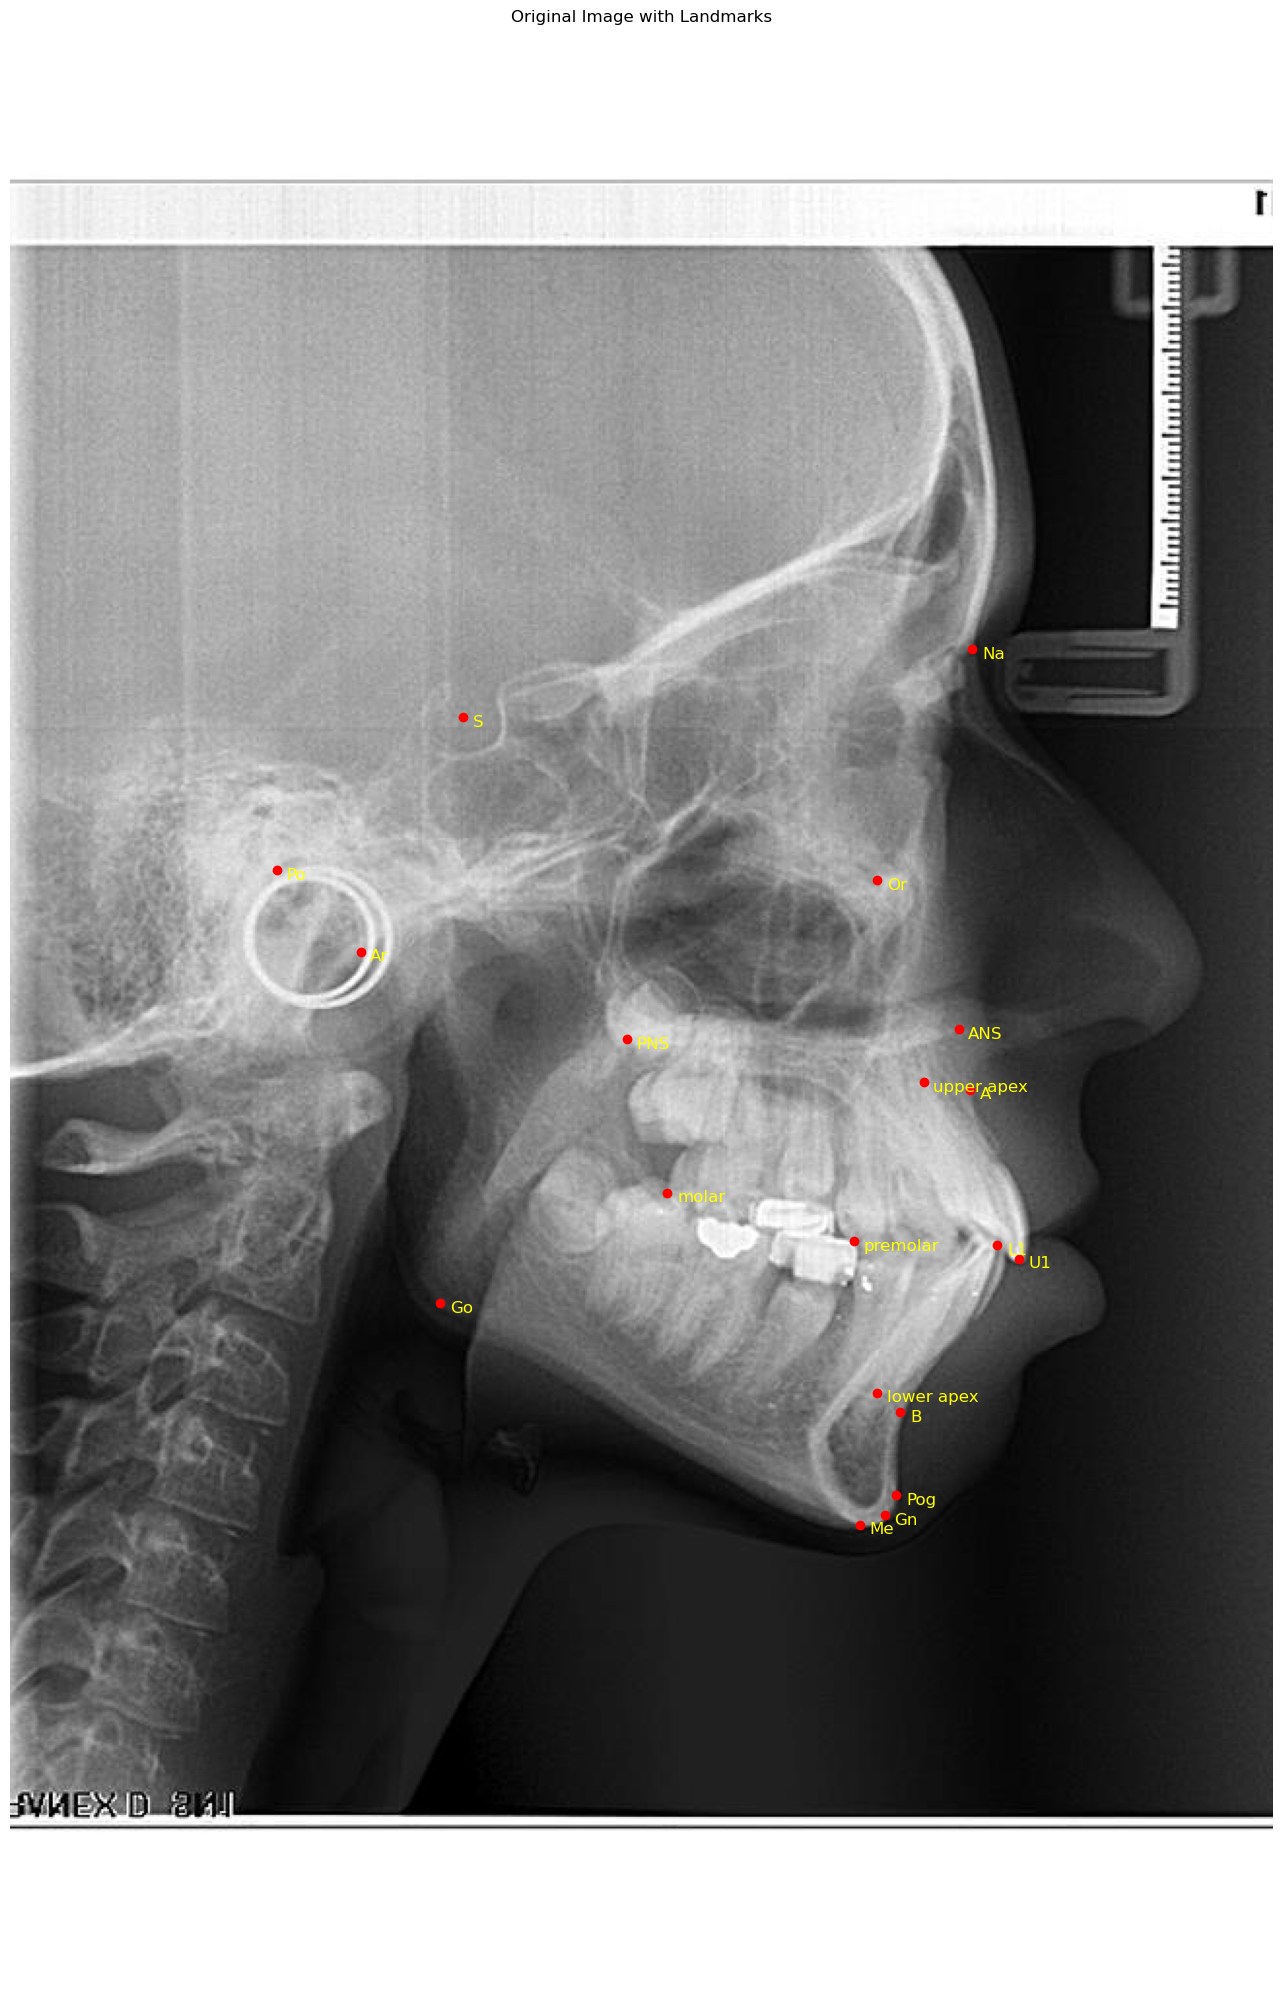

In [6]:
import random

# Randomly select a CSV file
random_csv_file = random.choice(train_inputImg)

# Randomly select a row of data
random_row = random.choice(random_csv_file.values)

img_landmarks = list(random_row)

# Read the corresponding image
image = cv2.imread('new1200/ceph400/ceph400/' + str(img_landmarks[0]), 0) / 255

# Display the image and landmarks
plt.figure(figsize=(20, 20))

# Display the original image
plt.imshow(image, cmap='gray')
plt.title('Original Image with Landmarks')

# Display the landmarks
for i, (landmark_idx, landmark_name) in enumerate(LANDMARK_NAMES.items()):
    if landmark_name != "null":
        x_idx = 2 * landmark_idx - 1
        y_idx = 2 * landmark_idx
        x = int(img_landmarks[x_idx])
        y = int(img_landmarks[y_idx])
        
        # Plot the landmark point
        plt.plot(x, y, 'ro')  # Red point
        plt.text(x + 5, y + 5, landmark_name, color='yellow', fontsize=12)  # Landmark name

plt.axis('off')  # Hide axes
plt.tight_layout()
plt.show()


In [7]:
def process_landmarks(row, image_shape, w=20):
    img_landmarks = list(row)
    Mask_Image = np.zeros((image_shape[0], image_shape[1], len(LANDMARK_NAMES)))
    landmark_positions = {}
    
    for i, (landmark_idx, landmark_name) in enumerate(LANDMARK_NAMES.items(), 1):
        x_idx = 2*landmark_idx - 1
        y_idx = 2*landmark_idx
        x = int(img_landmarks[x_idx])
        y = int(img_landmarks[y_idx])
        Mask_Image[y-w:y+w, x-w:x+w, i-1] = 1
        landmark_positions[landmark_name] = (x, y)
    
    return Mask_Image, landmark_positions

(256, 256, 1)
(256, 256, 19)
(256, 256, 1)


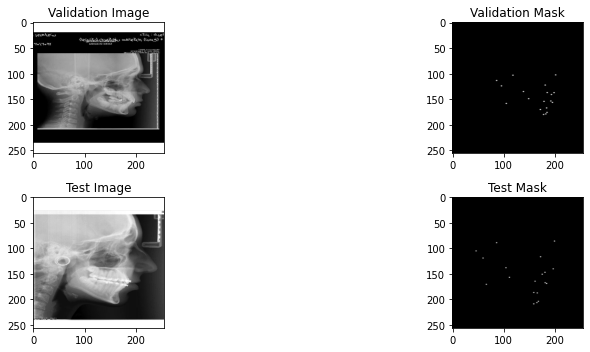

In [8]:
plt.rcParams["figure.figsize"] = (5,5)
val_test_inputImg = pd.read_csv('new1200/test2_senior.csv', 
                               delimiter=',',
                               dtype={col: float for col in range(1, 38)})
val_images = []
val_masks_orig = []
val_masks = []
test_images = []
test_masks_orig = []
test_masks = []
count = 1

for row in val_test_inputImg.values:
    img_landmarks = list(row)
    image = cv2.imread('new1200/ceph400/ceph400/' + str(img_landmarks[0]), 0) / 255
    Mask_Image = np.zeros((image.shape[0], image.shape[1], len(LANDMARK_NAMES)), dtype=np.uint8)
    for i, (landmark_idx, landmark_name) in enumerate(LANDMARK_NAMES.items()):
        x_idx = 2*landmark_idx - 1
        y_idx = 2*landmark_idx
        x = int(img_landmarks[x_idx])
        y = int(img_landmarks[y_idx])
        mask_layer = Mask_Image[:, :, i].astype(np.uint8)
        cv2.circle(mask_layer, (x, y), radius=4, color=255, thickness=-1)
        Mask_Image[:, :, i] = mask_layer
        Mask_Image[:, :, i] = cv2.GaussianBlur(Mask_Image[:, :, i].astype(np.float32), (5, 5), 0)


    new_image = cv2.resize(image,(256,256))
    new_image = new_image.reshape((new_image.shape[0],new_image.shape[1],1))
    resize_mask = cv2.resize(Mask_Image,(256,256))
    
    if count <= 50:
        val_images.append(new_image)
        val_masks_orig.append(Mask_Image)
        val_masks.append(resize_mask)
    else:
        test_images.append(new_image)
        test_masks_orig.append(Mask_Image)
        test_masks.append(resize_mask)
    
    count += 1

size = new_image.shape
print(size)
print(val_masks[0].shape)
print(val_images[0].shape)

# Modified visualization to handle multi-channel masks
plt.figure(figsize=(15, 5))

# Validation data
plt.subplot(221)
plt.imshow(val_images[0], cmap='gray')
plt.title("Validation Image")

plt.subplot(222)
composite_mask_val = np.sum(val_masks[0], axis=2)  # Combine all channels
plt.imshow(composite_mask_val, cmap='gray')
plt.title("Validation Mask")

# Test data
plt.subplot(223)
plt.imshow(test_images[0], cmap='gray')
plt.title("Test Image")

plt.subplot(224)
composite_mask_test = np.sum(test_masks[0], axis=2)  # Combine all channels
plt.imshow(composite_mask_test, cmap='gray')
plt.title("Test Mask")

plt.tight_layout()
plt.show()

In [9]:
train_images = [cv2.resize(img, (256, 256)).reshape(256, 256, 1) for img in train_images]
val_images = [cv2.resize(img, (256, 256)).reshape(256, 256, 1) for img in val_images]
train_masks = [cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
               .reshape(256, 256, len(LANDMARK_NAMES)) for mask in train_masks]

val_masks = [cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
             .reshape(256, 256, len(LANDMARK_NAMES)) for mask in val_masks]
train_images = [img for img in train_images if img.shape == (256, 256, 1)]
train_masks = [mask for mask in train_masks if mask.shape == (256, 256, len(LANDMARK_NAMES))]

val_images = [img for img in val_images if img.shape == (256, 256, 1)]
val_masks = [mask for mask in val_masks if mask.shape == (256, 256, len(LANDMARK_NAMES))]


In [10]:
train_images_stacked = np.stack(train_images, axis=0)
train_masks_stacked = np.stack(train_masks, axis=0)

val_images_stacked = np.stack(val_images, axis=0)
val_masks_stacked = np.stack(val_masks, axis=0)
val_data = (val_images_stacked, val_masks_stacked)

In [11]:
print(train_images_stacked.shape)
print(train_masks_stacked.shape)

(1012, 256, 256, 1)
(1012, 256, 256, 19)


In [12]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    
    conv = BatchNormalization()(conv)
    
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    conv = BatchNormalization()(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D((2,2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [13]:
def upsampling_block(expansive_input, contractive_input, n_filters=32, output=False):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,    # Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(merge)
    conv = BatchNormalization()(conv)
        
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
    conv = BatchNormalization()(conv)
    
    if not output:
        conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)
        conv = BatchNormalization()(conv)
    
    return conv

In [14]:
def unet_model(input_size, n_filters=64):
    
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs, n_filters)
    
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8, dropout_prob=0) # Include a dropout_prob of 0.3 for this layer
    # Include a dropout_prob of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(cblock4[0], n_filters*16, dropout_prob=0, max_pooling=False) 
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1],  n_filters*8, False)
    
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    # At each step, use half the number of filters of the previous block 
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4, False)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2, False)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters, True)

    #conv9 = Conv2D(n_filters,
    #             3,
    #             activation='relu',
    #             padding='same',
    #            kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(len(LANDMARK_NAMES), kernel_size=1, activation='sigmoid', padding='same')(ublock9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [15]:
def extract_landmark_positions(prediction, threshold=0.5):
    landmark_positions = {}
    for i, (_, landmark_name) in enumerate(LANDMARK_NAMES.items()):
        if landmark_name != "null":
            heatmap = prediction[:,:,i]
            y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
            if heatmap[y, x] > threshold:
                landmark_positions[landmark_name] = (x, y)
    return landmark_positions

def predict_landmarks(model, image):
    resized_image = cv2.resize(image, (256, 256))
    input_image = resized_image.reshape((1, 256, 256, 1))
    prediction = model.predict(input_image)[0]
    landmarks = extract_landmark_positions(prediction)
    scale_x = image.shape[1] / 256
    scale_y = image.shape[0] / 256
    scaled_landmarks = {
        name: (int(x * scale_x), int(y * scale_y))
        for name, (x, y) in landmarks.items()
    }
    return scaled_landmarks

In [16]:
epsilon = 1e-7
import tensorflow.keras.backend as K

def dice_coeff(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(K.cast(y_true, dtype='float32'))
    y_pred_f = K.flatten(K.cast(y_pred, dtype='float32'))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)


In [17]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
checkpoint_filepath = 'checkpoint_20channels'
checkpoint_20channels = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_dice_coeff',
    save_best_only=True)

In [18]:
print(size)
unet = unet_model(size)

(256, 256, 1)


In [19]:
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=dice_loss,
            metrics=[dice_coeff])

In [20]:
model_history = unet.fit(train_images_stacked, 
                        train_masks_stacked, 
                        batch_size=16,  # Reduced from 32
                        epochs=400,
                        validation_data=val_data,
                        callbacks=[reduce_lr, checkpoint_20channels])

Epoch 1/400
64/64 [==============================] - 50s 541ms/step - loss: 0.9190 - dice_coeff: 0.0813 - val_loss: 0.9557 - val_dice_coeff: 0.0436
Epoch 2/400
64/64 [==============================] - 31s 481ms/step - loss: 0.8437 - dice_coeff: 0.1575 - val_loss: 0.9619 - val_dice_coeff: 0.0375
Epoch 3/400
64/64 [==============================] - 31s 481ms/step - loss: 0.5546 - dice_coeff: 0.4492 - val_loss: 0.9198 - val_dice_coeff: 0.0768
Epoch 4/400
64/64 [==============================] - 31s 483ms/step - loss: -0.0682 - dice_coeff: 1.0725 - val_loss: 0.9189 - val_dice_coeff: 0.0842
Epoch 5/400
64/64 [==============================] - 31s 483ms/step - loss: -0.5106 - dice_coeff: 1.5049 - val_loss: 0.7417 - val_dice_coeff: 0.2415
Epoch 6/400
64/64 [==============================] - 31s 483ms/step - loss: -0.5982 - dice_coeff: 1.5994 - val_loss: 0.6845 - val_dice_coeff: 0.3251
Epoch 7/400
64/64 [==============================] - 31s 483ms/step - loss: -0.7001 - dice_coeff: 1.6998 - va

# Save the trained model

In [21]:
unet.save('Midterm_Model4.h5')

# Load model

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

LANDMARK_NAMES = {
    1: "S",    # Sella
    2: "Na",   # Nasion
    3: "Or",   # Orbitale
    4: "Po",   # Porion
    5: "A", # A point
    6: "B",    # B point
    7: "Pog",  # Pogonion
    8: "Me",   # Menton
    9: "Gn", # Gn point
    10: "Go",  # Gonion
    11: "L1", # L1 point
    12: "U1", # U1 point
    13: "lower apex",  # lower apex 
    14: "molar",  # molar point
    15: "upper apex",  # upper apex
    16: "premolar", # premolar point
    17: "PNS", # Posterior Nasal Spine
    18: "ANS",   # ANS point
    19: "Ar"   # Articulare
}

epsilon = 1e-7

def dice_coeff(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(K.cast(y_true, dtype='float32'))
    y_pred_f = K.flatten(K.cast(y_pred, dtype='float32'))
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coeff(y_true, y_pred)
model_path = "Midterm_Model4.h5"
unet = tf.keras.models.load_model(model_path, custom_objects={"dice_loss": dice_loss, "dice_coeff": dice_coeff})
unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization[0][0]        
______________________________________________________________________________________________

# Sample Test

🔍 Model output shape: (256, 256, 19)
Landmark S: max heatmap value = 1.0
Landmark Na: max heatmap value = 1.0
Landmark Or: max heatmap value = 1.0
Landmark Po: max heatmap value = 1.0
Landmark A: max heatmap value = 1.0
Landmark B: max heatmap value = 1.0
Landmark Pog: max heatmap value = 1.0
Landmark Me: max heatmap value = 1.0
Landmark Gn: max heatmap value = 1.0
Landmark Go: max heatmap value = 1.0
Landmark L1: max heatmap value = 1.0
Landmark U1: max heatmap value = 1.0
Landmark lower apex: max heatmap value = 1.0
Landmark molar: max heatmap value = 1.0
Landmark upper apex: max heatmap value = 1.0
Landmark premolar: max heatmap value = 1.0
Landmark PNS: max heatmap value = 1.0
Landmark ANS: max heatmap value = 1.0
Landmark Ar: max heatmap value = 1.0
📏 Scale x: 3.046875, scale y: 4.703125


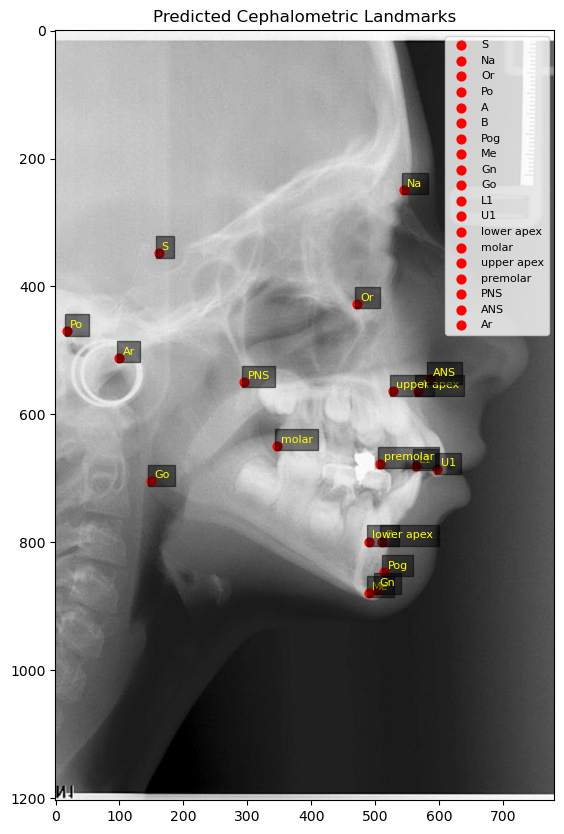

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# Reading the sample image from the path
image_path = "New_test.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Checking if the image is loaded correctly
if image is None:
    raise ValueError("Image not found. Please check the path.")

def extract_landmark_positions(prediction, threshold=0.1):
    landmark_positions = {}
    for i, (_, landmark_name) in enumerate(LANDMARK_NAMES.items()):
        if landmark_name != "null":
            heatmap = prediction[:, :, i]
            
            # Checking the maximum heatmap value
            max_value = np.max(heatmap)
            print(f"Landmark {landmark_name}: max heatmap value = {max_value}")

            y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
            
            if max_value > threshold:
                landmark_positions[landmark_name] = (x, y)
            else:
                print(f"⚠️ Warning: The maximum value for {landmark_name} is below the threshold, point removed.")
    
    return landmark_positions

def predict_landmarks(model, image):
    resized_image = cv2.resize(image, (256, 256))

    # Normalizing the model input
    input_image = resized_image.astype(np.float32) / 255.0  
    input_image = input_image.reshape((1, 256, 256, 1))

    # Model prediction
    prediction = model.predict(input_image)[0]

    # Checking the model output
    print(f"🔍 Model output shape: {prediction.shape}")

    # Extracting landmarks
    landmarks = extract_landmark_positions(prediction, threshold=0.01)

    # Calculating scaling factors
    scale_x = image.shape[1] / 256
    scale_y = image.shape[0] / 256
    print(f"📏 Scale x: {scale_x}, scale y: {scale_y}")

    # Scaling the landmarks to the original image dimensions
    scaled_landmarks = {
        name: (int(x * scale_x), int(y * scale_y))
        for name, (x, y) in landmarks.items()
    }

    return scaled_landmarks

# Getting the predicted landmarks
landmarks = predict_landmarks(unet, image)

# Visualizing the image and landmarks
def visualize_landmarks(image, landmarks):
    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap="gray")

    for name, (x, y) in landmarks.items():
        plt.scatter(x, y, color="red", s=40, label=name)
        plt.text(x + 5, y - 5, name, color="yellow", fontsize=8, bbox=dict(facecolor='black', alpha=0.5))

    plt.legend(loc="best", fontsize=8)
    plt.title("Predicted Cephalometric Landmarks")
    plt.show()

visualize_landmarks(image, landmarks)


# Post processing (adjustmets)¶
first step: makeing a dataframe for initial model predictions errors

In [59]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Mapping between the original point names and predicted point names
landmark_mapping = {
    'point_1': 'S', 'point_2': 'Na', 'point_3': 'Or', 'point_4': 'Po',
    'point_5': 'A', 'point_6': 'B', 'point_7': 'Pog', 'point_8': 'Me',
    'point_9': 'Gn', 'point_10': 'Go', 'point_11': 'L1', 'point_12': 'U1',
    'point_13': 'lower apex', 'point_14': 'molar', 'point_15': 'upper apex',
    'point_16': 'premolar', 'point_17': 'PNS', 'point_18': 'ANS', 'point_19': 'Ar'
}

def extract_landmark_positions(prediction, threshold):
    landmark_positions = {}
    for i, (_, landmark_name) in enumerate(LANDMARK_NAMES.items()):
        if landmark_name != "null":
            heatmap = prediction[:, :, i]
            y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
            if np.max(heatmap) > threshold:
                landmark_positions[landmark_name] = (x, y)
    return landmark_positions

def predict_landmarks(model, image):
    resized_image = cv2.resize(image, (256, 256)).astype(np.float32) / 255.0  
    input_image = resized_image.reshape((1, 256, 256, 1))
    prediction = model.predict(input_image)[0]
    landmarks = extract_landmark_positions(prediction, threshold=0.01)
    scale_x = image.shape[1] / 256
    scale_y = image.shape[0] / 256
    sn_length = 0
    return {name: (int(x * scale_x) + int(sn_length), int(y * scale_y) + int(sn_length)) for name, (x, y) in landmarks.items()}

# Paths to the CSV files containing the landmarks
csv_files = ['new1200/test1_senior.csv']
# Load the landmarks data
landmarks_data = [pd.read_csv(file, delimiter=',', dtype={col: float for col in range(1, 38)}) for file in csv_files]

# Load magnification factor CSV
magnification_df = pd.read_csv('magnification_factor.csv')  # Assuming it has columns 'image_name' and 'magnification_factor'

# Define list to store results
results = []

for df in landmarks_data:
    for i in range(len(df)):
        img_landmarks = list(df.values[i])
        image_path = f"new1200/ceph400/ceph400/{img_landmarks[0]}"
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue
        
        # Extract ground truth landmarks
        true_points = {}
        for landmark_idx in range(1, 20):  # 18 assumed points
            x_idx = 2 * landmark_idx - 1
            y_idx = 2 * landmark_idx
            true_points[f'point_{landmark_idx}'] = (int(img_landmarks[x_idx]), int(img_landmarks[y_idx]))
        
        # Predict landmarks using the model (assumed this function uses the model to predict)
        pred_landmarks = predict_landmarks(unet, image)
        
        # Calculate the S to Na distance for normalization
        x_s, y_s = true_points['point_1']  # Point S
        x_na, y_na = true_points['point_2']  # Point Na
        sn_distance = np.sqrt((x_na - x_s) ** 2 + (y_na - y_s) ** 2)  # Calculate the S to Na distance
        
        # Get the corresponding magnification factor from the CSV
        image_name = img_landmarks[0]  # Assuming the image name corresponds to the first column
        magnification_factor_row = magnification_df[magnification_df['image'] == image_name]
        
        if not magnification_factor_row.empty:
            magnification_factor = magnification_factor_row['magnification_factor'].values[0]
        else:
            # If no magnification factor is found, you can use a default value or handle it as needed
            magnification_factor = 0.15  # Default value

        # Store the data in a suitable DataFrame for learning
        for true_name, pred_name in landmark_mapping.items():
            if pred_name in pred_landmarks:  # Check if the predicted point exists
                x_true, y_true = true_points[true_name]
                x_pred, y_pred = pred_landmarks[pred_name]

                # Normalize coordinates
                norm_x_true = (x_true / sn_distance)
                norm_y_true = (y_true / sn_distance)
                norm_x_pred = (x_pred / sn_distance)
                norm_y_pred = (y_pred / sn_distance)

                # Correction vector
                delta_x = norm_x_true - norm_x_pred
                delta_y = norm_y_true - norm_y_pred

                # distance_error_normalized
                distance_error_normalized = np.sqrt(delta_x ** 2 + delta_y ** 2)
                distance_error = distance_error_normalized * sn_distance/1.5
                distance_error_mm = distance_error * magnification_factor 

                # Store in the results list
                results.append({
                    'image': img_landmarks[0],
                    'point': true_name,
                    'SN Length': sn_distance,
                    'x_pred': norm_x_pred,
                    'y_pred': norm_y_pred,
                    'x_true': norm_x_true,
                    'y_true': norm_y_true,
                    'Δx': delta_x,
                    'Δy': delta_y,
                    'distance_error_normalized': distance_error_normalized,
                    'distance_error': distance_error,
                    'magnification_factor': magnification_factor,
                    'distance_error_mm' : distance_error_mm
                })

# Create a DataFrame from the results
correction_df = pd.DataFrame(results)
correction_df.to_csv("initial_model_predictions.csv", index=False)
correction_df


,image,point,SN Length,x_pred,y_pred,x_true,y_true,Δx,Δy,distance_error_normalized,distance_error,magnification_factor,distance_error_mm
0,98.54.12.1.jpg,point_1,354.203331,0.485597,0.920375,0.494066,0.934491,0.008470,0.014116,0.016462,3.887301,0.156010,0.606460
1,98.54.12.1.jpg,point_2,354.203331,1.485023,0.858264,1.493492,0.900613,0.008470,0.042349,0.043187,10.198039,0.156010,1.591001
2,98.54.12.1.jpg,point_3,354.203331,1.267633,1.264810,1.261987,1.304336,-0.005646,0.039525,0.039927,9.428090,0.156010,1.470881
3,98.54.12.1.jpg,point_4,354.203331,0.183510,1.230931,0.191980,1.253517,0.008470,0.022586,0.024122,5.696002,0.156010,0.888636
4,98.54.12.1.jpg,point_5,354.203331,1.422912,1.637478,1.434204,1.654417,0.011293,0.016939,0.020359,4.807402,0.156010,0.750005
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2274,401.153.9.2.jpg,point_15,315.158690,1.618232,2.186200,1.703904,2.249660,0.085671,0.063460,0.106615,22.400397,0.140233,3.141273
2275,401.153.9.2.jpg,point_16,315.158690,1.564291,2.401965,1.589675,2.427349,0.025384,0.025384,0.035898,7.542472,0.140233,1.057703
2276,401.153.9.2.jpg,point_17,315.158690,1.091514,2.129086,1.139109,2.160816,0.047595,0.031730,0.057202,12.018504,0.140233,1.685390
2277,401.153.9.2.jpg,point_18,315.158690,1.795921,2.186200,1.891111,2.236968,0.095190,0.050768,0.107882,22.666667,0.140233,3.178613


# Second Step: make a dataframe for adjsted predictions

In [62]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

landmark_mapping = {
    'point_1': 'S', 'point_2': 'Na', 'point_3': 'Or', 'point_4': 'Po',
    'point_5': 'A', 'point_6': 'B', 'point_7': 'Pog', 'point_8': 'Me',
    'point_9': 'Gn', 'point_10': 'Go', 'point_11': 'L1', 'point_12': 'U1',
    'point_13': 'lower apex', 'point_14': 'molar', 'point_15': 'upper apex',
    'point_16': 'premolar', 'point_17': 'PNS', 'point_18': 'ANS', 'point_19': 'Ar'
}

def extract_landmark_positions(prediction, threshold):
    landmark_positions = {}
    for i, (_, landmark_name) in enumerate(LANDMARK_NAMES.items()):
        if landmark_name != "null":
            heatmap = prediction[:, :, i]
            y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
            if np.max(heatmap) > threshold:
                landmark_positions[landmark_name] = (x, y)
    return landmark_positions

def predict_landmarks_adjusted(model, image):
    resized_image = cv2.resize(image, (256, 256)).astype(np.float32) / 255.0  
    input_image = resized_image.reshape((1, 256, 256, 1))
    prediction = model.predict(input_image)[0]
    landmarks = extract_landmark_positions(prediction, threshold=0.01)
    scale_x = image.shape[1] / 256
    scale_y = image.shape[0] / 256
    sn_length = image.shape[1] / 60  # Calculate 1/10 of the SN length
    landmarks = {name: (int(x * scale_x) + int(sn_length), int(y * scale_y) + int(sn_length)) for name, (x, y) in landmarks.items()}
    landmarks = adjust_landmarks(landmarks, landmark_adjustments)  # Apply adjustments
    return landmarks

# Paths to the CSV files containing the landmarks
csv_files = ['new1200/test1_senior.csv']
# Load the landmarks data
landmarks_data = [pd.read_csv(file, delimiter=',', dtype={col: float for col in range(1, 38)}) for file in csv_files]

# Load correction data
correction_df = pd.read_csv("initial_model_predictions.csv")
# Calculate mean error for each point
mean_errors = correction_df.groupby('point').agg(
    mean_delta_x=('Δx', 'mean'),
    mean_delta_y=('Δy', 'mean'),
    mean_distance_error=('distance_error', 'mean')
).reset_index()

# Extract data for the desired points
landmark_adjustments = mean_errors[mean_errors['point'].isin([
    'point_1', 'point_2', 'point_3', 'point_4', 'point_5', 'point_6', 'point_7', 'point_8', 'point_9',
    'point_10', 'point_11', 'point_12', 'point_13', 'point_14', 'point_15', 'point_16', 'point_17', 'point_18'
])]

# Adjust landmarks based on correction data
def adjust_landmarks(landmarks, adjustments):
    adjusted_landmarks = {}

    # Calculate SN distance based on predicted points
    if 'S' in landmarks and 'Na' in landmarks:
        x_s, y_s = landmarks['S']
        x_na, y_na = landmarks['Na']
        sn_distance = np.sqrt((x_na - x_s) ** 2 + (y_na - y_s) ** 2)
    else:
        sn_distance = 1  # Default value if points are not found

    for point, (x, y) in landmarks.items():
        if point in adjustments['point'].values:
            delta_x = adjustments.loc[adjustments['point'] == point, 'mean_delta_x'].values[0] * sn_distance
            delta_y = adjustments.loc[adjustments['point'] == point, 'mean_delta_y'].values[0] * sn_distance
            adjusted_landmarks[point] = (x + delta_x, y + delta_y)
        else:
            adjusted_landmarks[point] = (x, y)
    
    return adjusted_landmarks

# Define list to store results
results = []

# Process each image and calculate the adjustments
for df in landmarks_data:
    for i in range(len(df)):
        img_landmarks = list(df.values[i])
        image_path = f"new1200/ceph400/ceph400/{img_landmarks[0]}"
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue
        
        # Extract ground truth landmarks
        true_points = {}
        for landmark_idx in range(1, 20):  # 18 assumed points
            x_idx = 2 * landmark_idx - 1
            y_idx = 2 * landmark_idx
            true_points[f'point_{landmark_idx}'] = (int(img_landmarks[x_idx]), int(img_landmarks[y_idx]))
        
        # Predict landmarks using the model (assumed this function uses the model to predict)
        pred_landmarks = predict_landmarks_adjusted(unet, image)
        
        # Calculate the S to Na distance for normalization
        x_s, y_s = true_points['point_1']  # Point S
        x_na, y_na = true_points['point_2']  # Point Na
        sn_distance = np.sqrt((x_na - x_s) ** 2 + (y_na - y_s) ** 2)  # Calculate the S to Na distance
        
        # Store the data in a suitable DataFrame for learning
        for true_name, pred_name in landmark_mapping.items():
            if pred_name in pred_landmarks:  # Check if the predicted point exists
                x_true, y_true = true_points[true_name]
                x_pred, y_pred = pred_landmarks[pred_name]

                # Normalize coordinates
                norm_x_true = (x_true / sn_distance)
                norm_y_true = (y_true / sn_distance)
                norm_x_pred = (x_pred / sn_distance)
                norm_y_pred = (y_pred / sn_distance)

                # Correction vector
                delta_x = norm_x_true - norm_x_pred
                delta_y = norm_y_true - norm_y_pred

                # distance_error_normalized
                distance_error_normalized = np.sqrt(delta_x ** 2 + delta_y ** 2)
                distance_error = distance_error_normalized * sn_distance/2.5
                distance_error_mm = distance_error * magnification_factor 

                # Store in the results list
                results.append({
                    'image': img_landmarks[0],
                    'point': true_name,
                    'SN Length': sn_distance,
                    'x_pred': norm_x_pred,
                    'y_pred': norm_y_pred,
                    'x_true': norm_x_true,
                    'y_true': norm_y_true,
                    'Δx': delta_x,
                    'Δy': delta_y,
                    'distance_error_normalized': distance_error_normalized,
                    'distance_error': distance_error,
                    'magnification_factor': magnification_factor,
                    'distance_error_mm' : distance_error_mm
                })

# Create a DataFrame from the results
adjsted = pd.DataFrame(results)
adjsted.to_csv("adjsted_model_predictions.csv", index=False)
adjsted


,image,point,SN Length,x_pred,y_pred,x_true,y_true,Δx,Δy,distance_error_normalized,distance_error,magnification_factor,distance_error_mm
0,98.54.12.1.jpg,point_1,354.203331,0.516652,0.951431,0.494066,0.934491,-0.022586,-0.016939,0.028232,4.000000,0.140233,0.560932
1,98.54.12.1.jpg,point_2,354.203331,1.516078,0.889320,1.493492,0.900613,-0.022586,0.011293,0.025252,3.577709,0.140233,0.501713
2,98.54.12.1.jpg,point_3,354.203331,1.298689,1.295866,1.261987,1.304336,-0.036702,0.008470,0.037667,5.336666,0.140233,0.748376
3,98.54.12.1.jpg,point_4,354.203331,0.214566,1.261987,0.191980,1.253517,-0.022586,-0.008470,0.024122,3.417601,0.140233,0.479260
4,98.54.12.1.jpg,point_5,354.203331,1.453967,1.668533,1.434204,1.654417,-0.019763,-0.014116,0.024286,3.440930,0.140233,0.482532
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2274,401.153.9.2.jpg,point_15,315.158690,1.656308,2.224276,1.703904,2.249660,0.047595,0.025384,0.053941,6.800000,0.140233,0.953584
2275,401.153.9.2.jpg,point_16,315.158690,1.602367,2.440041,1.589675,2.427349,-0.012692,-0.012692,0.017949,2.262742,0.140233,0.317311
2276,401.153.9.2.jpg,point_17,315.158690,1.129590,2.167162,1.139109,2.160816,0.009519,-0.006346,0.011440,1.442221,0.140233,0.202247
2277,401.153.9.2.jpg,point_18,315.158690,1.833997,2.224276,1.891111,2.236968,0.057114,0.012692,0.058507,7.375636,0.140233,1.034307


<Figure size 1200x600 with 0 Axes>

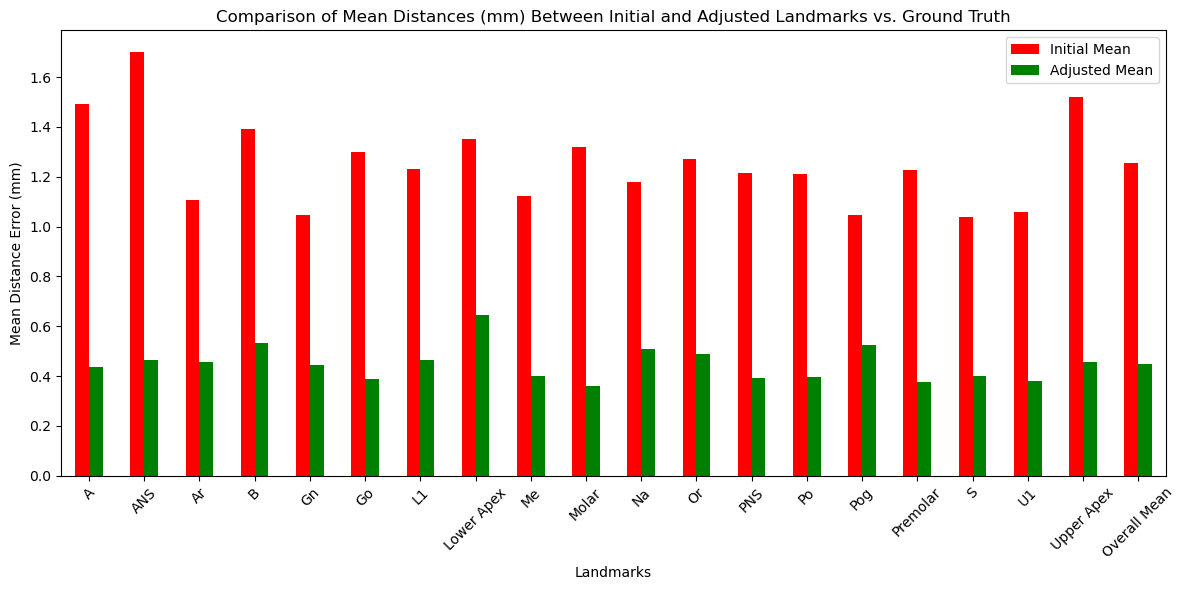

Initial Overall Mean Distance Error: 1.25 mm
Initial Overall Std Dev: 0.58 mm
Adjusted Overall Mean Distance Error: 0.45 mm
Adjusted Overall Std Dev: 0.30 mm


In [80]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from CSV files
initial_df = pd.read_csv("initial_model_predictions.csv")
adjusted_df = pd.read_csv("adjsted_model_predictions.csv")

# Define dictionary of landmark names
LANDMARK_NAMES = {
    1: "S",       # Sella
    2: "Na",      # Nasion
    3: "Or",      # Orbitale
    4: "Po",      # Porion
    5: "A",       # A point
    6: "B",       # B point
    7: "Pog",     # Pogonion
    8: "Me",      # Menton
    9: "Gn",      # Gnathion
    10: "Go",     # Gonion
    11: "L1",     # Lower Incisor
    12: "U1",     # Upper Incisor
    13: "Lower Apex",
    14: "Molar",
    15: "Upper Apex",
    16: "Premolar",
    17: "PNS",    # Posterior Nasal Spine
    18: "ANS",    # Anterior Nasal Spine
    19: "Ar"      # Articulare
}

# Function to rename landmarks
def rename_landmarks(df):
    # Extract numeric part from strings like 'point_1'
    df['point'] = df['point'].str.extract('(\d+)').astype(int)
    
    # Replace point numbers with actual landmark names
    df['point'] = df['point'].apply(lambda x: LANDMARK_NAMES.get(x, f'Unknown ({x})'))
    return df

# Apply renaming to dataframes
initial_df = rename_landmarks(initial_df)
adjusted_df = rename_landmarks(adjusted_df)

# Calculate mean and standard deviation of Euclidean distances for each landmark
mean_dist_initial = initial_df.groupby('point')['distance_error_mm'].mean()
std_dist_initial = initial_df.groupby('point')['distance_error_mm'].std()

mean_dist_adjusted = adjusted_df.groupby('point')['distance_error_mm'].mean()
std_dist_adjusted = adjusted_df.groupby('point')['distance_error_mm'].std()

# Calculate overall mean and standard deviation (all points)
overall_mean_initial = initial_df['distance_error_mm'].mean()
overall_std_initial = initial_df['distance_error_mm'].std()

overall_mean_adjusted = adjusted_df['distance_error_mm'].mean()
overall_std_adjusted = adjusted_df['distance_error_mm'].std()

# Combine statistics into a comparison DataFrame
comparison_df = pd.DataFrame({
    'Initial Mean': mean_dist_initial,
    'Initial Std Dev': std_dist_initial,
    'Adjusted Mean': mean_dist_adjusted,
    'Adjusted Std Dev': std_dist_adjusted
})

# Add overall statistics
comparison_df.loc['Overall Mean'] = [overall_mean_initial, overall_std_initial, overall_mean_adjusted, overall_std_adjusted]

# Plot comparison bar chart
plt.figure(figsize=(12, 6))
comparison_df[['Initial Mean', 'Adjusted Mean']].plot(kind='bar', color=['red', 'green'], figsize=(12, 6))

# Chart settings
plt.title('Comparison of Mean Distances (mm) Between Initial and Adjusted Landmarks vs. Ground Truth')
plt.xlabel('Landmarks')
plt.ylabel('Mean Distance Error (mm)')
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()

# Print overall statistics
print(f"Initial Overall Mean Distance Error: {overall_mean_initial:.2f} mm")
print(f"Initial Overall Std Dev: {overall_std_initial:.2f} mm")
print(f"Adjusted Overall Mean Distance Error: {overall_mean_adjusted:.2f} mm")
print(f"Adjusted Overall Std Dev: {overall_std_adjusted:.2f} mm")


# Random_test for ground truth, predicted and adjusted landmarks

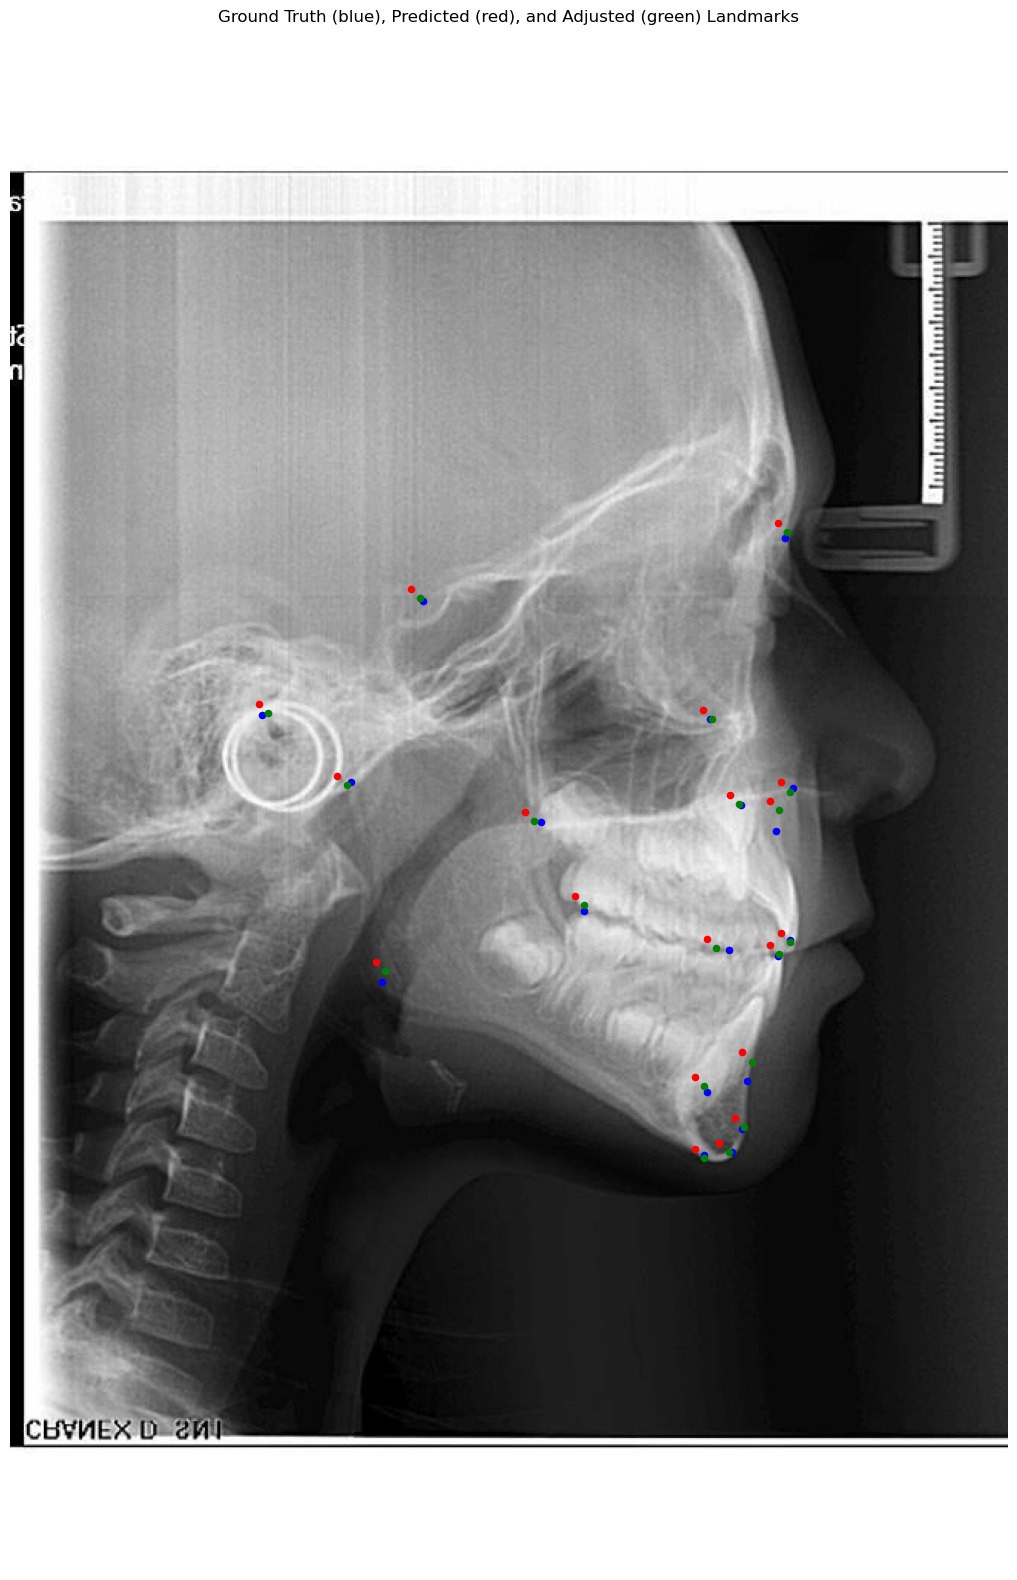

In [79]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Randomly select a sample from the dataset
random_sample_idx = random.randint(0, len(landmarks_data) - 1)
df = landmarks_data[random_sample_idx]
img_landmarks = list(df.values[random.randint(0, len(df) - 1)])  # Random sample from this dataset
image_path = f"new1200/ceph400/ceph400/{img_landmarks[0]}"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

if image is None:
    raise ValueError(f"Unable to read image from path {image_path}")

# Extract ground truth points
true_points = {}
for landmark_idx in range(1, 20):  # Example with 18 landmarks
    x_idx = 2 * landmark_idx - 1
    y_idx = 2 * landmark_idx
    true_points[f'point_{landmark_idx}'] = (int(img_landmarks[x_idx]), int(img_landmarks[y_idx]))

# Load correction data from CSV
correction_df = pd.read_csv("landmark_correction_data.csv")

# Calculate mean error for each landmark
mean_errors = correction_df.groupby('point').agg(
    mean_delta_x=('Δx', 'mean'),
    mean_delta_y=('Δy', 'mean'),
    mean_distance_error=('distance_error', 'mean')
).reset_index()

# Filter corrections for desired landmarks
landmark_adjustments = mean_errors[mean_errors['point'].isin([
    'point_1', 'point_2', 'point_3', 'point_4', 'point_5', 'point_6', 'point_7', 'point_8', 'point_9',
    'point_10', 'point_11', 'point_12', 'point_13', 'point_14', 'point_15', 'point_16', 'point_17', 'point_18'
])]

# Adjust landmarks based on correction data
def adjust_landmarks(landmarks, adjustments):
    adjusted_landmarks = {}

    # Calculate SN distance based on predicted points
    if 'S' in landmarks and 'Na' in landmarks:
        x_s, y_s = landmarks['S']
        x_na, y_na = landmarks['Na']
        sn_distance = np.sqrt((x_na - x_s) ** 2 + (y_na - y_s) ** 2)
    else:
        sn_distance = 1  # Default value if points are not found

    for point, (x, y) in landmarks.items():
        if point in adjustments['point'].values:
            delta_x = adjustments.loc[adjustments['point'] == point, 'mean_delta_x'].values[0] * sn_distance
            delta_y = adjustments.loc[adjustments['point'] == point, 'mean_delta_y'].values[0] * sn_distance
            adjusted_landmarks[point] = (x + delta_x, y + delta_y)
        else:
            adjusted_landmarks[point] = (x, y)

    return adjusted_landmarks

# Store results
results = []

# Predict landmarks with adjustment
def predict_landmarks_adjusted(model, image):
    resized_image = cv2.resize(image, (256, 256)).astype(np.float32) / 255.0
    input_image = resized_image.reshape((1, 256, 256, 1))
    prediction = model.predict(input_image)[0]
    landmarks = extract_landmark_positions(prediction, threshold=0.01)
    scale_x = image.shape[1] / 256
    scale_y = image.shape[0] / 256
    sn_length = image.shape[1] / 100  # SN-based shift if needed
    landmarks = {name: (int(x * scale_x) + int(sn_length), int(y * scale_y) + int(sn_length)) for name, (x, y) in landmarks.items()}
    landmarks = adjust_landmarks(landmarks, landmark_adjustments)  # Apply adjustments
    return landmarks

# Predict landmarks without adjustment
def predict_landmarks(model, image):
    resized_image = cv2.resize(image, (256, 256)).astype(np.float32) / 255.0
    input_image = resized_image.reshape((1, 256, 256, 1))
    prediction = model.predict(input_image)[0]
    landmarks = extract_landmark_positions(prediction, threshold=0.01)
    scale_x = image.shape[1] / 256
    scale_y = image.shape[0] / 256
    sn_length = 0
    return {name: (int(x * scale_x) + int(sn_length), int(y * scale_y) + int(sn_length)) for name, (x, y) in landmarks.items()}

# Predict landmarks
adjusted_landmarks = predict_landmarks_adjusted(unet, image)
initial_pred = predict_landmarks(unet, image)

# Prepare image for visualization
image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Plot ground truth, predicted, and adjusted landmarks
plt.figure(figsize=(20, 20))
plt.imshow(image_color)

# Ground truth points
for point, (x, y) in true_points.items():
    plt.scatter(x, y, color='blue', label=f'{point} (True)', s=20)

# Predicted landmarks
for point, (x, y) in initial_pred.items():
    plt.scatter(x, y, color='red', label=f'{point} (Predicted)', s=20)

# Adjusted landmarks
for point, (x, y) in adjusted_landmarks.items():
    plt.scatter(x, y, color='green', label=f'{point} (Adjusted)', s=20)

plt.title("Ground Truth (blue), Predicted (red), and Adjusted (green) Landmarks")
plt.axis('off')
plt.show()


# SPEED test

In [3]:
import cv2
import time  # for measuring time

# Path to the CSV files containing landmark points
csv_files = ['new1200/test1_senior.csv']

# Loading the landmark data
landmarks_data = [pd.read_csv(file, delimiter=',', dtype={col: float for col in range(1, 38)}) for file in csv_files]

# List to store processing times for each image
time_taken = []

# Speed test process
for df in landmarks_data:
    for i in range(len(df)):
        img_landmarks = list(df.values[i])
        image_path = f"new1200/ceph400/ceph400/{img_landmarks[0]}"
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue
        
        start_time = time.time()  # Start timing
        
        # Predicting landmarks with the model
        pred_landmarks = predict_landmarks(unet, image)
        
        # Store processing time
        time_taken.append(time.time() - start_time)

# Calculate the average and standard deviation of the times
avg_time = np.mean(time_taken)
std_time = np.std(time_taken)

# Display average and standard deviation results
print(f"Average processing time: {avg_time:.4f} seconds")
print(f"Standard deviation of processing time: {std_time:.4f} seconds")


Average processing time: 0.4539 seconds
Standard deviation of processing time: 0.0491 seconds


# Other metrics

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Load dataframes
correction_df_new = pd.read_csv("initial_model_predictions.csv")
correction_df_new_adjusted = pd.read_csv("adjsted_model_predictions.csv")

# DICE score function
def dice_score(true_points, pred_points):
    intersection = np.sum(np.array(true_points) * np.array(pred_points))
    return 2. * intersection / (np.sum(true_points) + np.sum(pred_points))

# MAE function
def mean_absolute_error(true_points, pred_points):
    return np.mean(np.abs(np.array(true_points) - np.array(pred_points)))

# RMSE function
def root_mean_squared_error(true_points, pred_points):
    return np.sqrt(np.mean((np.array(true_points) - np.array(pred_points)) ** 2))

# IoU function
def iou(true_points, pred_points):
    true_points = np.array(true_points)
    pred_points = np.array(pred_points)
    intersection = np.count_nonzero(true_points == pred_points)
    union = np.count_nonzero(true_points) + np.count_nonzero(pred_points) - intersection
    return intersection / union if union > 0 else 0

# Extract true and predicted values for both dataframes
true_x_values = correction_df_new['x_true'].values
pred_x_values = correction_df_new['x_pred'].values
true_y_values = correction_df_new['y_true'].values
pred_y_values = correction_df_new['y_pred'].values

true_x_values_adjusted = correction_df_new_adjusted['x_true'].values
pred_x_values_adjusted = correction_df_new_adjusted['x_pred'].values
true_y_values_adjusted = correction_df_new_adjusted['y_true'].values
pred_y_values_adjusted = correction_df_new_adjusted['y_pred'].values

# Compute metrics for both dataframes
def calculate_metrics(true_x, pred_x, true_y, pred_y):
    dice_x = dice_score(true_x, pred_x)
    dice_y = dice_score(true_y, pred_y)
    mae_x = mean_absolute_error(true_x, pred_x)
    mae_y = mean_absolute_error(true_y, pred_y)
    rmse_x = root_mean_squared_error(true_x, pred_x)
    rmse_y = root_mean_squared_error(true_y, pred_y)
    precision_x = precision_score(true_x > 0, pred_x > 0, average='binary', zero_division=0)
    recall_x = recall_score(true_x > 0, pred_x > 0, average='binary', zero_division=0)
    f1_x = f1_score(true_x > 0, pred_x > 0, average='binary', zero_division=0)
    accuracy_x = accuracy_score(true_x > 0, pred_x > 0)
    precision_y = precision_score(true_y > 0, pred_y > 0, average='binary', zero_division=0)
    recall_y = recall_score(true_y > 0, pred_y > 0, average='binary', zero_division=0)
    f1_y = f1_score(true_y > 0, pred_y > 0, average='binary', zero_division=0)
    accuracy_y = accuracy_score(true_y > 0, pred_y > 0)
    iou_x = iou(true_x, pred_x)
    iou_y = iou(true_y, pred_y)
    return {
        'dice_x': dice_x, 'dice_y': dice_y, 'mae_x': mae_x, 'mae_y': mae_y,
        'rmse_x': rmse_x, 'rmse_y': rmse_y, 'precision_x': precision_x, 'precision_y': precision_y,
        'recall_x': recall_x, 'recall_y': recall_y, 'f1_x': f1_x, 'f1_y': f1_y,
        'accuracy_x': accuracy_x, 'accuracy_y': accuracy_y, 'iou_x': iou_x, 'iou_y': iou_y
    }

metrics_original = calculate_metrics(true_x_values, pred_x_values, true_y_values, pred_y_values)
metrics_adjusted = calculate_metrics(true_x_values_adjusted, pred_x_values_adjusted, true_y_values_adjusted, pred_y_values_adjusted)

# Create comparison table
metrics_df = pd.DataFrame({
    'Metric': ['DICE x', 'DICE y', 'MAE x', 'MAE y', 'RMSE x', 'RMSE y', 'Precision x', 'Precision y', 
               'Recall x', 'Recall y', 'F1 x', 'F1 y', 'Accuracy x', 'Accuracy y', 'IoU x', 'IoU y'],
    'Original': [metrics_original['dice_x'], metrics_original['dice_y'], metrics_original['mae_x'], metrics_original['mae_y'], 
                 metrics_original['rmse_x'], metrics_original['rmse_y'], metrics_original['precision_x'], metrics_original['precision_y'], 
                 metrics_original['recall_x'], metrics_original['recall_y'], metrics_original['f1_x'], metrics_original['f1_y'],
                 metrics_original['accuracy_x'], metrics_original['accuracy_y'], metrics_original['iou_x'], metrics_original['iou_y']],
    'Adjusted': [metrics_adjusted['dice_x'], metrics_adjusted['dice_y'], metrics_adjusted['mae_x'], metrics_adjusted['mae_y'], 
                 metrics_adjusted['rmse_x'], metrics_adjusted['rmse_y'], metrics_adjusted['precision_x'], metrics_adjusted['precision_y'], 
                 metrics_adjusted['recall_x'], metrics_adjusted['recall_y'], metrics_adjusted['f1_x'], metrics_adjusted['f1_y'],
                 metrics_adjusted['accuracy_x'], metrics_adjusted['accuracy_y'], metrics_adjusted['iou_x'], metrics_adjusted['iou_y']]
})

print(metrics_df)

# Prepare for comparison plot
metrics_for_plot = ['dice_x', 'dice_y', 'mae_x', 'mae_y', 'rmse_x', 'rmse_y', 'precision_x', 'precision_y', 
                    'recall_x', 'recall_y', 'f1_x', 'f1_y', 'accuracy_x', 'accuracy_y', 'iou_x', 'iou_y']
metrics_for_plot_titles = ['DICE x', 'DICE y', 'MAE x', 'MAE y', 'RMSE x', 'RMSE y', 'Precision x', 'Precision y', 
                           'Recall x', 'Recall y', 'F1 x', 'F1 y', 'Accuracy x', 'Accuracy y', 'IoU x', 'IoU y']


# Final prediction

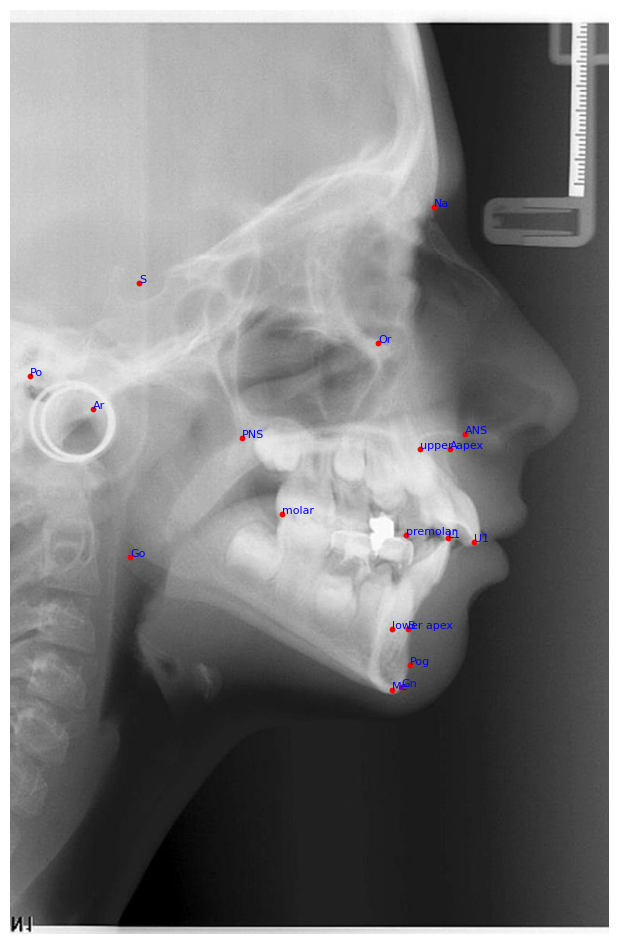

In [68]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import pandas as pd

LANDMARK_NAMES = {
    1: "S",    # Sella
    2: "Na",   # Nasion
    3: "Or",   # Orbitale
    4: "Po",   # Porion
    5: "A",    # A point
    6: "B",    # B point
    7: "Pog",  # Pogonion
    8: "Me",   # Menton
    9: "Gn",   # Gn point
    10: "Go",  # Gonion
    11: "L1",  # L1 point
    12: "U1",  # U1 point
    13: "lower apex",  # lower apex
    14: "molar",  # molar point
    15: "upper apex",  # upper apex
    16: "premolar",  # premolar point
    17: "PNS",  # Posterior Nasal Spine
    18: "ANS",  # ANS point
    19: "Ar"    # Articulare
}


def extract_landmark_positions(prediction, threshold):
    landmark_positions = {}
    for i, (_, landmark_name) in enumerate(LANDMARK_NAMES.items()):
        if landmark_name != "null":
            heatmap = prediction[:, :, i]
            y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
            if np.max(heatmap) > threshold:
                landmark_positions[landmark_name] = (x, y)
    return landmark_positions

def predict_landmarks(model, image):
    resized_image = cv2.resize(image, (256, 256)).astype(np.float32) / 255.0  
    input_image = resized_image.reshape((1, 256, 256, 1))
    prediction = model.predict(input_image)[0]
    landmarks = extract_landmark_positions(prediction, threshold=0.01)
    scale_x = image.shape[1] / 256
    scale_y = image.shape[0] / 256
    sn_length = image.shape[1] / 60  # Calculating 1/10th of the SN length
    return {name: (int(x * scale_x) + int(sn_length), int(y * scale_y) + int(sn_length)) for name, (x, y) in landmarks.items()}


def visualize_landmarks(image, landmarks):
    # Adjust image size
    plt.figure(figsize=(12, 12))  # Increase display size
    plt.imshow(image, cmap="gray")
    for name, (x, y) in landmarks.items():
        plt.scatter(x, y, color="red", s=10)
        plt.text(x, y, f"{name}", color="blue", fontsize=8)  # Display landmark names
    plt.axis("off")
    plt.show()


# Load data from CSV file
correction_df = pd.read_csv("landmark_correction_data.csv")

# Calculate mean error for each point
mean_errors = correction_df.groupby('point').agg(
    mean_delta_x=('Δx', 'mean'),
    mean_delta_y=('Δy', 'mean'),
    mean_distance_error=('distance_error', 'mean')
).reset_index()

# Extract data for the desired points
landmark_adjustments = mean_errors[mean_errors['point'].isin([
    'point_1', 'point_2', 'point_3', 'point_4', 'point_5', 'point_6', 'point_7', 'point_8', 'point_9',
    'point_10', 'point_11', 'point_12', 'point_13', 'point_14', 'point_15', 'point_16', 'point_17', 'point_18'
])]


# Adjust landmarks based on correction data
def adjust_landmarks(landmarks, adjustments):
    adjusted_landmarks = {}

    # Calculate SN distance based on predicted points
    if 'S' in landmarks and 'Na' in landmarks:
        x_s, y_s = landmarks['S']
        x_na, y_na = landmarks['Na']
        sn_distance = np.sqrt((x_na - x_s) ** 2 + (y_na - y_s) ** 2)
    else:
        sn_distance = 1  # Default value if points are not found

    for point, (x, y) in landmarks.items():
        if point in adjustments['point'].values:
            delta_x = adjustments.loc[adjustments['point'] == point, 'mean_delta_x'].values[0] * sn_distance
            delta_y = adjustments.loc[adjustments['point'] == point, 'mean_delta_y'].values[0] * sn_distance
            adjusted_landmarks[point] = (x + delta_x, y + delta_y)
        else:
            adjusted_landmarks[point] = (x, y)

    return adjusted_landmarks


def extract_landmark_positions(prediction, threshold):
    landmark_positions = {}
    for i, (_, landmark_name) in enumerate(LANDMARK_NAMES.items()):
        if landmark_name != "null":
            heatmap = prediction[:, :, i]
            y, x = np.unravel_index(np.argmax(heatmap), heatmap.shape)
            if np.max(heatmap) > threshold:
                landmark_positions[landmark_name] = (x, y)
    return landmark_positions

def predict_landmarks(model, image):
    resized_image = cv2.resize(image, (256, 256)).astype(np.float32) / 255.0  
    input_image = resized_image.reshape((1, 256, 256, 1))
    prediction = model.predict(input_image)[0]
    landmarks = extract_landmark_positions(prediction, threshold=0.01)  # Reducing the threshold
    scale_x = image.shape[1] / 256
    scale_y = image.shape[0] / 256
    sn_length = image.shape[1] / 100  # Calculating 1/10th of the SN length
    landmarks = {name: (int(x * scale_x) + int(sn_length), int(y * scale_y) + int(sn_length)) for name, (x, y) in landmarks.items()}
    landmarks = adjust_landmarks(landmarks, landmark_adjustments)  # Apply adjustments
    return landmarks

def visualize_landmarks(image, landmarks):
    # Adjust image size
    plt.figure(figsize=(12, 12))  # Increase display size
    plt.imshow(image, cmap="gray")
    for name, (x, y) in landmarks.items():
        plt.scatter(x, y, color="red", s=10)
        plt.text(x, y, f"{name}", color="blue", fontsize=8)  # Display landmark names
    plt.axis("off")
    plt.show()

# Read image and predict landmarks
image_path = "New_test.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Image not found. Please check the path.")

landmarks = predict_landmarks(unet, image)
visualize_landmarks(image, landmarks)


In [40]:
for name, coords in landmarks.items():
     print(f"{name}={coords}")


S=(168, 355)
Na=(552, 256)
Or=(479, 434)
Po=(25, 477)
A=(573, 571)
B=(518, 806)
Pog=(521, 853)
Me=(497, 886)
Gn=(509, 881)
Go=(156, 712)
L1=(570, 688)
U1=(604, 693)
lower apex=(497, 806)
molar=(354, 656)
upper apex=(534, 571)
premolar=(515, 684)
PNS=(302, 557)
ANS=(592, 552)
Ar=(107, 519)
